Everything can be done with the TPOTEstimator class. All other classes (TPOTRegressor, TPOTClassifier, TPOTSymbolicClassifier, TPOTSymbolicRegression, TPOTGeneticFeatureSetSelector, etc.) are actually just different default settings for TPOTEstimator.


By Default, TPOT will generate pipelines with a default set of classifiers or regressors as roots (this depends on whether classification is set to true or false). All other nodes are selected from a default list of selectors and transformers. Note: This differs from the TPOT1 behavior where by default classifiers and regressors can appear in locations other than the root. You can modify the the search space for leaves, inner nodes, and roots (final classifiers) separately through built in options or custom configuration dictionaries.

In this tutorial we will walk through using the built in configurations, creating custom configurations, and using nested configurations.

## Configuration Dictionaries

The default configuration includes several machine learning estimators from sklearn. Sometimes we may want to change or restrict what is allowed. 

In TPOT2, we specify three different configuration dictionaries to indicate which modules can go where on the graph

1. root_config_dict  : Specifies the modules allowed to be placed in the root node. This is the final classifier or regressor. (It can also technically be used as a transformer if the scoring function knows that.). You are guaranteed a root node in every graph pipeline.
2. inner_config_dict : Specifies the modules allowed to be placed all nodes that are not the root node. If leaf_config_dict is set to None, then leaves will be pulled from this list. You are not guaranteed a node from this list however. It is still possible to end up with a graph that contains only a single root, or a root and a leaf even if this is set.
3. leaf_config_dict  : Specifies the modules allowed to be placed as leafs. Unlike inner_config_dict, you are guaranteed to have a leaf node from this list if it is set. The smallest possible graph would thus be \[leaf->root\]. 

Note: TPOT1 internally divided the methods inside the configuration dictionary into selectors/transformers/estimators and treated them differently. TPOT2 does not. 

## Built in Defaults

Each configuration dictionary parameter has access to the same default parameters. The default parameters can also be grouped into a list to combine their search spaces.

- 'selectors' : A selection of sklearn Selector methods.
- 'classifiers' : A selection of sklearn Classifier methods.
- 'regressors' : A selection of sklearn Regressor methods.
- 'transformers' : A selection of sklearn Transformer methods.
- 'arithmetic_transformer' : A selection of sklearn Arithmetic Transformer methods that replicate symbolic classification/regression operators.
- 'passthrough' : A node that just passes though the input. Useful for passing through raw inputs into inner nodes.
- 'feature_set_selector' : A selector that pulls out specific subsets of columns from the data. Only well defined as a leaf.
                            Subsets are set with the subsets parameter.
- list : a list of strings out of the above options to include the corresponding methods in the configuration dictionary.


## Other search space parameters

1. linear_pipeline : If True, pipelines will be linear
2. max_size :  The maximum number of nodes in the pipeline.



## defining configuration dictionaries

Configuration dictionaries are python dictionaries where the keys are the method types and the values are optuna-compatible functions that take in a trial and return a hyperparameter dictionary.


Configuration dictionaries can also be nested. Meaning that the search space for that node, will be a graph defined by the nested dictionary. More on that later in the tutorial. 

With these three types of configuration dictionaries plus nesting, one can define very specific search spaces. More on nesting later.

0.9958333333333332


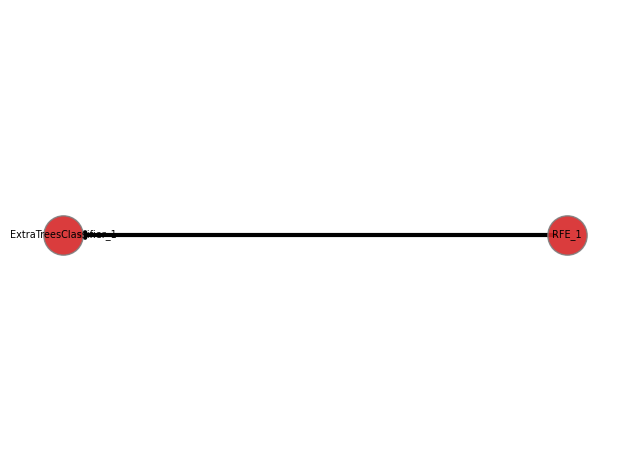

In [1]:
# A Linear pipeline starting with a selector, followed by 0 to 4 transformers, and ending with a classifier.

import tpot2
import sklearn
import sklearn.datasets

est = tpot2.TPOTEstimator(  population_size=10,
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= "transformers",
                            leaf_config_dict="selectors",
                            linear_pipeline=True,
                            max_size=6,

                            early_stop=5,
                            verbose=0)

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

1.0


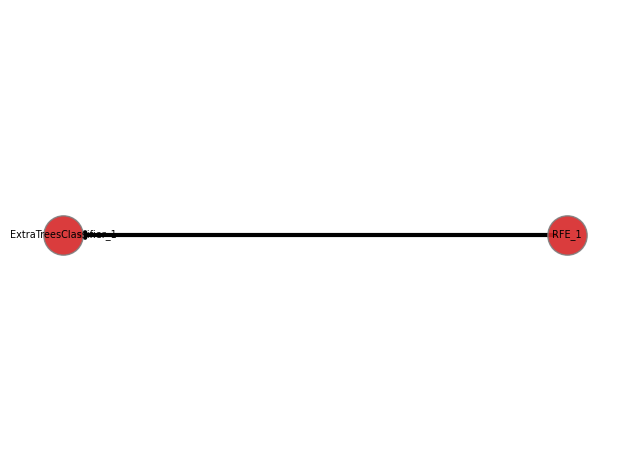

In [2]:
# A Graph pipeline starting with at least one selector as a leaf, potentially followed by a series
# of stacking classifiers or transformers, and ending with a classifier. The graph will have at most 15 nodes.

import tpot2
import sklearn
import sklearn.datasets
import numpy as np

est = tpot2.TPOTEstimator(  population_size=10,
                            generations=5,
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            root_config_dict="classifiers",
                            inner_config_dict= ["classifiers","transformers"],
                            leaf_config_dict="selectors",
                            max_size=15,

                            early_stop=5,
                            verbose=0)

scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))

est.fitted_pipeline_.plot()

## Custom Configuration Dictionaries


Next, we will show how to use these features to define a graph pipeline search space similar to symbolic classification.

The following defines a pipeline where leafs select a single feature, inner nodes perform arithmetic, and logistic regression is used as a final classifier.

The arithmetic transformer and feature set selection of single columns are built in configurations with the "arithmetic_transformer" and "feature_set_selector" options respectively. 

There is not a built in configuration for a single logistic regression so we have to manually define one.

### Parameter function
To start, we create a function that takes in a trial object. This object takes in a search space, and outputs a parameter. This is designed to be compatible with the optuna trial class. More information on available functions within trial can be found here: https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html

The suggested parameters should be put into a dictionary that has the model parameters as keys with their corresponding values.

Note: For optuna optimization to work, it is important to add '_{name}' to each of the names parameters. With large graphs, names of parameters will likely clash. The name parameter here allows TPOT2 to make sure each parameter for each node has a unique label. 

Note: This will be simplified in a future release.


In [3]:
import tpot2
import numpy as np
def params_LogisticRegression(trial, name=None):
    params = {}
    params['solver'] = trial.suggest_categorical(name=f'solver_{name}',
                                                 choices=[f'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
    params['dual'] = False
    params['penalty'] = 'l2'
    params['C'] = trial.suggest_float(f'C_{name}', 1e-4, 1e4, log=True)
    params['l1_ratio'] = None
    if params['solver'] == 'liblinear':
        params['penalty'] = trial.suggest_categorical(name=f'penalty_{name}', choices=['l1', 'l2'])
        if params['penalty'] == 'l2':
            params['dual'] = trial.suggest_categorical(name=f'dual_{name}', choices=[True, False])
        else:
            params['penalty'] = 'l1'

    params['class_weight'] = trial.suggest_categorical(name=f'class_weight_{name}', choices=['balanced'])
    param_grid = {'solver': params['solver'],
                  'penalty': params['penalty'],
                  'dual': params['dual'],
                  'multi_class': 'auto',
                  'l1_ratio': params['l1_ratio'],
                  'C': params['C'],
                  }
    return param_grid

### configuration dictionary
A configuration dictionary has the python Types for the designed estimator as keys, and the function as values.

In [4]:

from sklearn.linear_model import LogisticRegression
root_config_dict = { LogisticRegression : params_LogisticRegression }

1.0


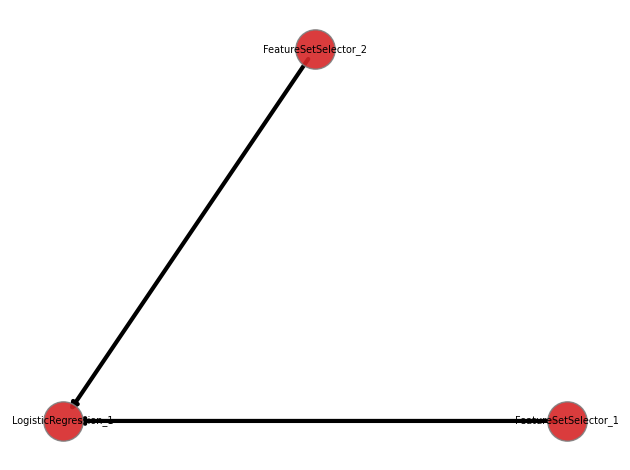

In [5]:


est = tpot2.TPOTEstimator(population_size=20,generations=10, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            inner_config_dict= "arithmetic_transformer",
                            leaf_config_dict="feature_set_selector",
                            root_config_dict=root_config_dict,
                            )

#load iris
scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

## Recursive Configuration Dictionaries (EXPERIMENTAL)

Configuration dictionaries can also be nested. If the string "Recursive" is used in place of a type, the node that would go in that place will now represent a graph with those restrictions. 

All inputs to the recursive node will be merged and input to all the leaves within the recursive graph. The output of the graph will be sent to the outputs of the node that represents it. 

This is handy for restricting the search space of the model as well as setting specific ensembling templates.

(Currently) These are all flattened and merged into a single graph when exported as a graph pipeline. In the future these could be used for ensemble methods such as boosting/stacking/etc.

Note that this is not a new instance of the TPOT2 estimator, and it does not independently run GP. Rather this recursive node just sets a search space restriction for that node.

In [6]:
transformer_config_dictionary = "transformers"
selector_config_dictionary = "feature_set_selector"
classifier_config_dictionary = root_config_dict 

#Some example search spaces with nested graphs

#pipelines of the shape selector->transformer
st_params =  { 
                            'root_config_dict':transformer_config_dictionary,
                            'leaf_config_dict':selector_config_dictionary,
                            'inner_confic_dict': None,
                            'max_size' : 2, 
                            'linear_pipeline' : True}

#pipelines of the shape (selector->transformer) -> classifier. 
# This is equivalent to setting TPOT1 to use the 'Selector-Transformer-Classifier' template
st_c_params = { 
                            'root_config_dict': classifier_config_dictionary,
                            'leaf_config_dict': {"Recursive" : st_params},
                            'inner_confic_dict': None,
                            'max_size' : 2, 
                            'linear_pipeline' : True}

#pipelines of the shape ((selector->transformer) -> classifier)*N) -> classifier
#This is like having an ensemble of 'Selector-Transformer-Classifier' models with a final meta classifier
st_c_ensemble_params = { 
                            'root_config_dict': classifier_config_dictionary,
                            'leaf_config_dict': {"Recursive" : st_c_params},
                            'inner_confic_dict': None,
                            'max_size' : 6, 
                            'linear_pipeline' : True}

In [7]:
# linear pipelines of the shape selector->transformer->classifier
est = tpot2.TPOTEstimator(population_size=20,generations=10, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            **st_c_params,
                            )

#load iris
scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()

TypeError: TPOTEstimator.__init__() got an unexpected keyword argument 'inner_confic_dict'

0.998015873015873


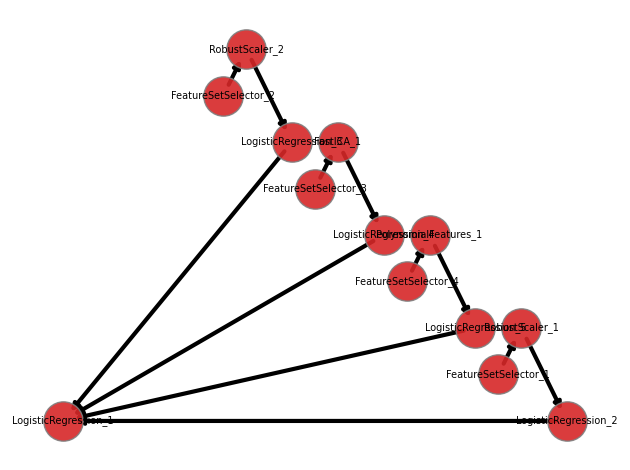

In [ ]:
# ensembles of linear pipelines of the shape selector->transformer->classifier ensemble pipeline with a final meta classifier
est = tpot2.TPOTEstimator(population_size=20,generations=10, 
                            scorers=['roc_auc_ovr'],
                            scorers_weights=[1],
                            classification=True,
                            **st_c_ensemble_params,
                            )

#load iris
scorer = sklearn.metrics.get_scorer('roc_auc_ovo')
X, y = sklearn.datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.75, test_size=0.25)
est.fit(X_train, y_train)
print(scorer(est, X_test, y_test))
est.fitted_pipeline_.plot()